# Betrachtung des Energieaufwands unterschiedlicher Elektromotoren

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In diesem Notebook wird betrachtet, wie sich unterschiedliche Effizienzkennlinien von Elektromotoren auf den Energiebedarf des Elektromotors auswirken. Dafür wird eine gegebene mechanische Last betrachtet, die von den Elektromotoren erbracht werden soll. Für unterschiedliche Elektromotoren mit unterschiedlichen Effizienzkennlinien werden sich unterschiedliche Bedarfe elektrischer Energie ergeben.

## Der Wirkungsgrad

Die benötigte elektrische Leistung $P_{el}$ ergibt sich aus der zu erbringenden mechansichen Leistung $P_{mech}$ und dem Wirkungsgrad $\eta$ des Elektromotors gemäß der folgenden Gleichung \ref{eta-elec-mot}

\begin{equation}\label{eta-elec-mot}
P_{el} = \eta \cdot P_{mech} \\
\end{equation}

Weiterhin ist der Wirkungsgrad nicht konstant, sondern vom Verhältnis der zu erbringenden mechanischen Leistung zur mechanischen Nennleistung $P_{rel}=\frac{P_{mech}}{P_{nenn}}$ abhängig. An dieser Stelle wird hierfür der folgende exponentielle Zusammenhang in Gleichung \ref{eta-of-p} gewählt:

\begin{equation}\label{eta-of-p}
\eta(P_{rel}) = \eta_{max} \cdot \left(1 - e^{(-a \cdot P_{rel})} \right)
\end{equation}

Als freie Parameter tauchen $a$ und $\eta_{max}$ auf, die den Verlauf der Kennlinie beeinflussen. In der folgenden Abbildung sind ein paar unterschiedliche Kennlinien dargestellt:

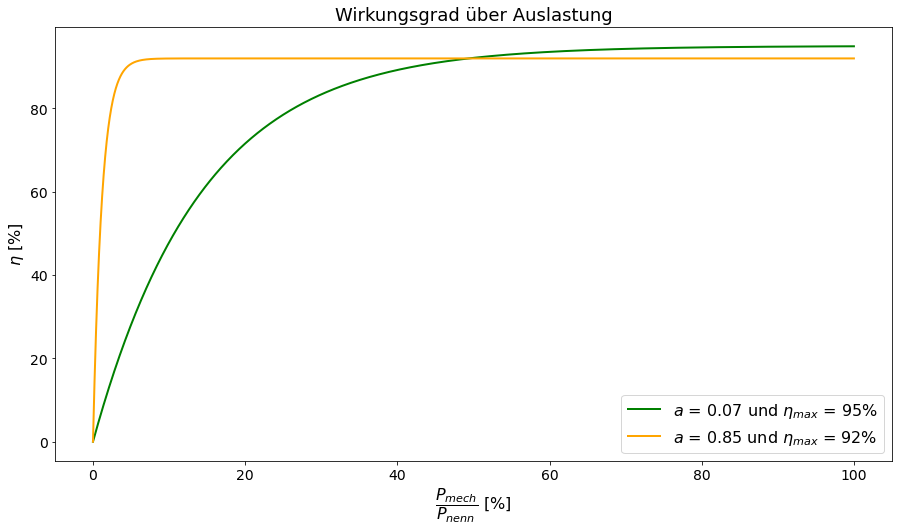

In [3]:
# 0.1 % Auflösung
p_rel = np.linspace(0, 100, 1001)

def eta_of_p(x, a, eta_max):
    return eta_max * (1 - np.exp(-a * x))

# auch mal andere Kombinationen ausprobieren
params = {'green': (0.07, 95), 'orange': (0.85, 92)}

fig, ax = plt.subplots(figsize=(15, 8))
for param in params:
    ax.plot(p_rel, eta_of_p(p_rel, *params[param]), label=(r'$a$ = ' + str(params[param][0]) + ' und $\eta_{max}$ = '
                                                   + str(params[param][1]) + '%'), color=param)
    
ax.legend()
ax.set_xlabel(r'$\dfrac{P_{mech}}{P_{nenn}}$ [%]')
ax.set_ylabel(r'$\eta$ [%]')
ax.set_title('Wirkungsgrad über Auslastung');


Es ist zu erkennen, dass beispielsweise die grüne Kennlinie den höheren stationären Endwert $\eta_{max}$ erreicht, allerdings besitzt sie nur eine schwächere Steigung $a$. Das heißt, im Teillastbetrieb, könnte ein Motor, der diese Effizienzkennlinie aufweist, durchaus weniger effektiv betrieben werden, als ein Motor mit der orangenen Kennlinie. Im Nennbetrieb wäre aber der Motor mit der grünen Kennlinie effizienter.

## Das mechanische Lastprofil

Als mechanisches Lastprofil wird ein  elektrisches SLP verwendet.

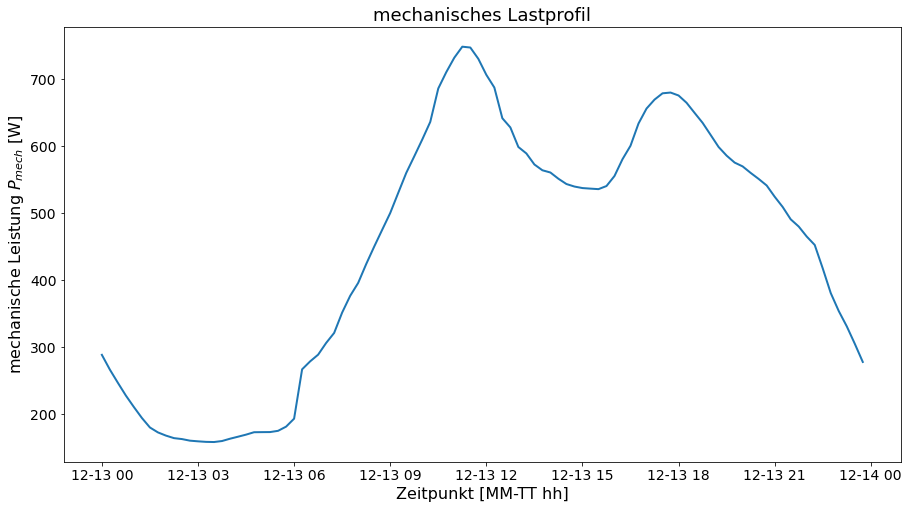

In [4]:
load = pd.read_csv('../data/SLP_Nuernberg.csv')
load.rename(columns={'Unnamed: 0': 'Zeitpunkt', 'MWh.1': 'mechanische Leistung [W]'}, inplace=True)
load.set_index(load.columns[0], inplace=True)
load.index = pd.DatetimeIndex(load.index)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(load)
ax.set_xlabel('Zeitpunkt [MM-TT hh]')
ax.set_ylabel(r'mechanische Leistung $P_{mech}$ [W]')
ax.set_title('mechanisches Lastprofil');

Jetzt werden zwei unterschiedliche Elektromotoren genutzt um das mechanische Latsprofil abzufahren und die benötigte Energie verglichen. Beide Motoren besitzen eine Nennleistung von $P_{nenn} = 800 W$. Allerdings besitzt ein Motor die grüne Kennline und der andere Motor die orangene Kennlinie.

In [5]:
# auch mal andere Werte probieren
p_nenn = 800

load['p/p_nenn'] = load['mechanische Leistung [W]'] / p_nenn

def calc_p_mech(color):
    def wrapper(x):
        global eta_of_p
        global params
        global p_rel
        global p_nenn
        
        eff = eta_of_p(p_rel, *params[color])

        # x aufbereiten auf ganzprozentig
        x_index = int(round(x*1000, 0))
        
        # schauen, was hierfür der Wirkungsgrad ist
        eta = (eff[x_index]/100)

        # hier müsste eigentlich mit der mechanischen leistung [W] an diesem Zeitpunkt multipliziert werden
        p_mech = x*p_nenn / eta

        return p_mech
    
    return wrapper
        

load['elektrische Leistung [W] grüner Motor'] = load['p/p_nenn'].apply(calc_p_mech('green'))
load['elektrische Leistung [W] orangener Motor'] = load['p/p_nenn'].apply(calc_p_mech('orange'))

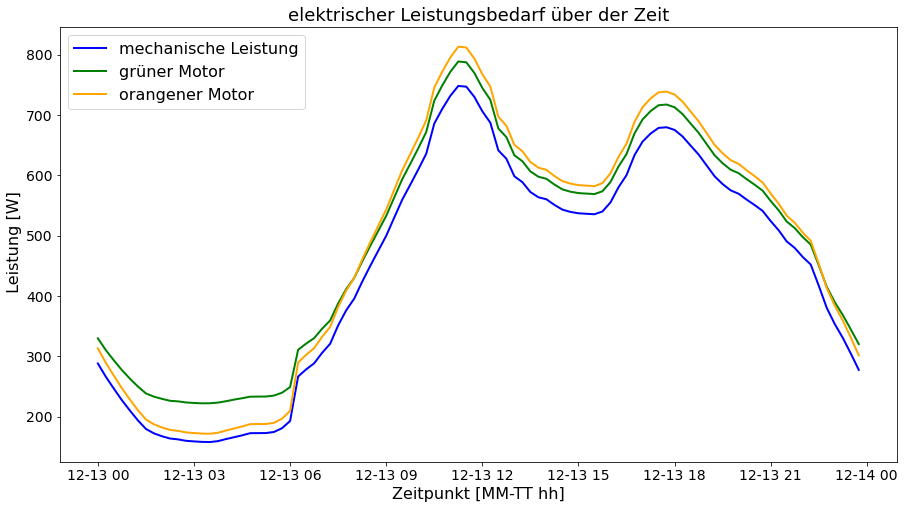

In [6]:
to_plot = {0: 'mechanische Leistung',2: 'grüner Motor', 3: 'orangener Motor'}
colors = {0: 'blue', 2: 'green', 3: 'orange'}
fig, ax = plt.subplots(figsize=(15, 8))
for lines in to_plot:
    ax.plot(load[load.columns[int(lines)]], label=to_plot[lines], color=colors[lines])

ax.legend()
ax.set_title('elektrischer Leistungsbedarf über der Zeit')
ax.set_xlabel('Zeitpunkt [MM-TT hh]')
ax.set_ylabel(' Leistung [W]');

Es ist zu erkennen, dass der grüne Motor (dessen Effizienz für hohe Auslastungen besser ist) in Bereichen hoher Auslastungen tatsächlich weniger elektrische Leistung bezieht. In Bereichen geringer Auslastung bezieht allerdings der orangene Motor (dessen Effizienz für geringe Auslastungen besser ist) weniger elektrische Leistung.

Zuletzt soll betrachtet werden, welcher Motor über den gesamten Tag betrachtet weniger elektrische Energie bezieht:

In [7]:
energy_green = load['elektrische Leistung [W] grüner Motor'].sum() / 4000
energy_orange = load['elektrische Leistung [W] orangener Motor'].sum() / 4000

print(f'Energiebedarf des grünen Motors: {round(energy_green, 2)} kWh')
print(f'Energiebedarf des orangenen Motors: {round(energy_orange, 2)} kWh')

Energiebedarf des grünen Motors: 11.73 kWh
Energiebedarf des orangenen Motors: 11.66 kWh


Trotz der scheinbar "schlechteren" Effizienzkurve, ist der orangene Motor etwas sparsamer als der grüne Motor. Man sollte also immer darauf achten, den richtigen Motor für den richtigen Zweck zu verwenden.

Würde das mechanische Lastprofil längere Zeit in Bereichen hoher Auslastungen verlaufen, dann wäre der grüne Motor aber auch wieder besser.